# Mortality Rate Estimation 

The data found for previous disease outbreaks will come into use to tune the model for regression. We will mostly focus on other Coronaviruses outbreaks (i.e., SARS or MERS) to construct the estimates.

In [28]:
import pandas as pd
from pandas.plotting import autocorrelation_plot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

plt.rcParams['figure.figsize']=[40,20]
plt.rcParams['font.size']=22
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.labelsize'] = 24

## SARS

The dataset on the 2003 SARS outbreak was found on Kaggle and based on WHO reports during the crisis.

In [30]:
sars_ts = pd.read_excel('data/SARS.xlsx', usecols=list(range(4)), parse_dates=[1]).set_index('Date', drop=True)

## Overall Mortality Rate

First, we must calculate the survival rate $S_{SARS}$ from our data. A value of $90.36\%$ is in line with the rate in [this paper](doi:10.1016/j.socscimed.2006.08.004) (as per Wikipedia, as I have no access to the paper). 

In [41]:
def calculate_survival_rate(ts, dead_col='Dead', infected_col='Infected'):
    return 1 - ts.iloc[-1][dead_col] / ts.iloc[-1][infected_col]

In [44]:
S_sars = calculate_survival_rate(sars_ts, dead_col='Mortality')
S_sars

0.9036387341472087

## Estimate Mortality Curve

Given that the mortality data available is only aggregate level, we must consider the sum of deltas to have a smoother objective function to estimate.

In [32]:
smooth_sars_ts = sars_ts.diff().resample('W').sum()

In [76]:
def estimate_death_curve(X, d, S):
    alpha_space = np.linspace(0.0001, 0.1, 1000)

    T = X.size
    
    minimum_K = None
    minimum_distance = None
    minimum_d_hat = None

    for alpha in alpha_space:
        K = int(np.ceil(np.log(S) / np.log(1 - alpha)))
        
        d_hat = np.zeros(T)

        for t in range(T):
            for k in range(min(t, K)):
                d_hat[t] += alpha * ((1 - alpha) ** k) * X[t - k]

        distance = np.linalg.norm(d - d_hat)

        if minimum_distance is None or distance < minimum_distance:
            minimum_distance = distance
            minimum_d_hat = d_hat
            minimum_K = K
            
            
    print(f"Minimum distance={minimum_distance}\nMinimum K={minimum_K}")
            
    return pd.DataFrame.from_dict({"d": d, "d_hat": minimum_d_hat})

Minimum distance=68.90524026234436
Minimum d_hat=[  0.          25.026       43.106941    53.87614177  65.33830472
  91.64703117  97.28469287 101.32437876  98.65180981  93.37990224
  71.22105473  43.67394627  23.32820332  14.00914771   6.14276348
   1.55055572   0.6256339 ]
Minimum K=5


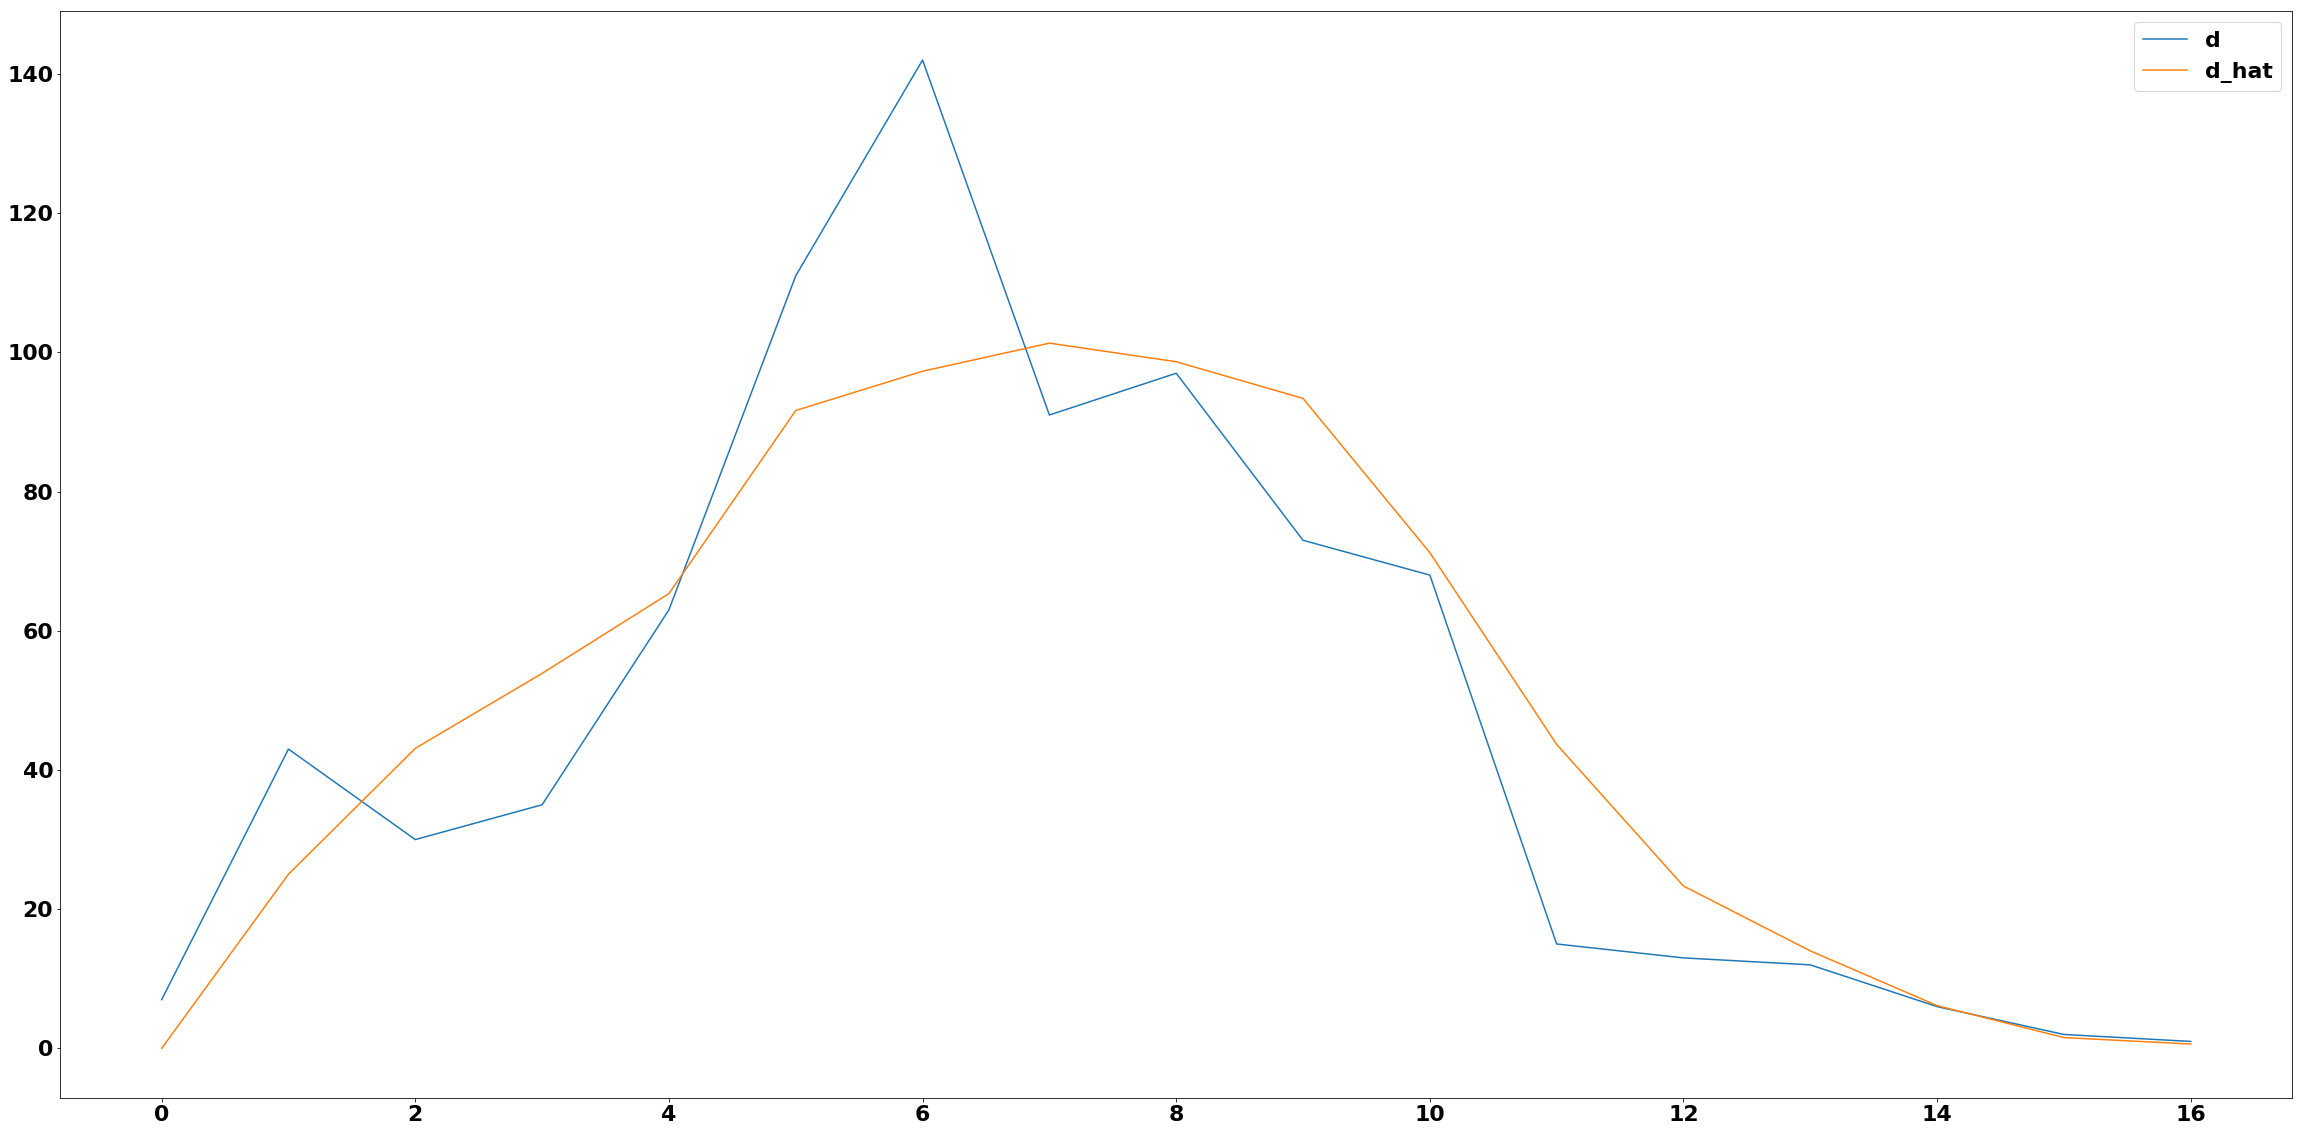

In [60]:
estimate_death_curve(
    smooth_sars_ts['Infected'].values,
    smooth_sars_ts['Mortality'].values,
    S_sars
).plot()

## MERS

In [61]:
mers_ts = pd.read_csv('data/MERS/MERS_middle_east_timeline.csv', parse_dates=[0], index_col=0)

In [69]:
smooth_mers_ts = mers_ts.diff().resample('2W').sum()

In [70]:
S_mers = calculate_survival_rate(mers_ts)
S_mers

0.7354709418837675

Minimum distance=14.091014856394814
Minimum d_hat=[0.         1.1688     1.73675888 2.44419857 2.32067259 2.37248681
 2.37341082 2.59482308 2.45091329 2.15199857 2.54393287 2.57400154
 6.17916328 6.54838648 5.53239962 2.32918678 1.66966718 2.72739809
 3.27244075 2.55546575 1.69345885 0.96125492 1.65254168 1.69209711
 1.79942159 1.12851865 1.53709217 2.00327063 1.88548681 1.05724462
 0.23805147 0.0974     0.08791324 0.07935049 0.         0.
 0.0974     0.08791324 0.07935049 0.         0.         0.
 0.         0.         0.         0.1948     0.56542648 0.89995394
 1.05865492 1.15605492 0.85436816 0.77686569 0.53789021 0.80347795
 1.19215394 3.65999464 7.78962415 8.57496249 6.80575207 3.60740594
 3.11558779 2.51129026 1.55047307 0.39675245 0.3896     0.83865296
 1.14656816 1.04060541 0.87334168 0.69659119 0.51127795 0.44141422
 0.64477697 1.09475394 1.4292814  1.78278238 1.47160886]
Minimum K=3


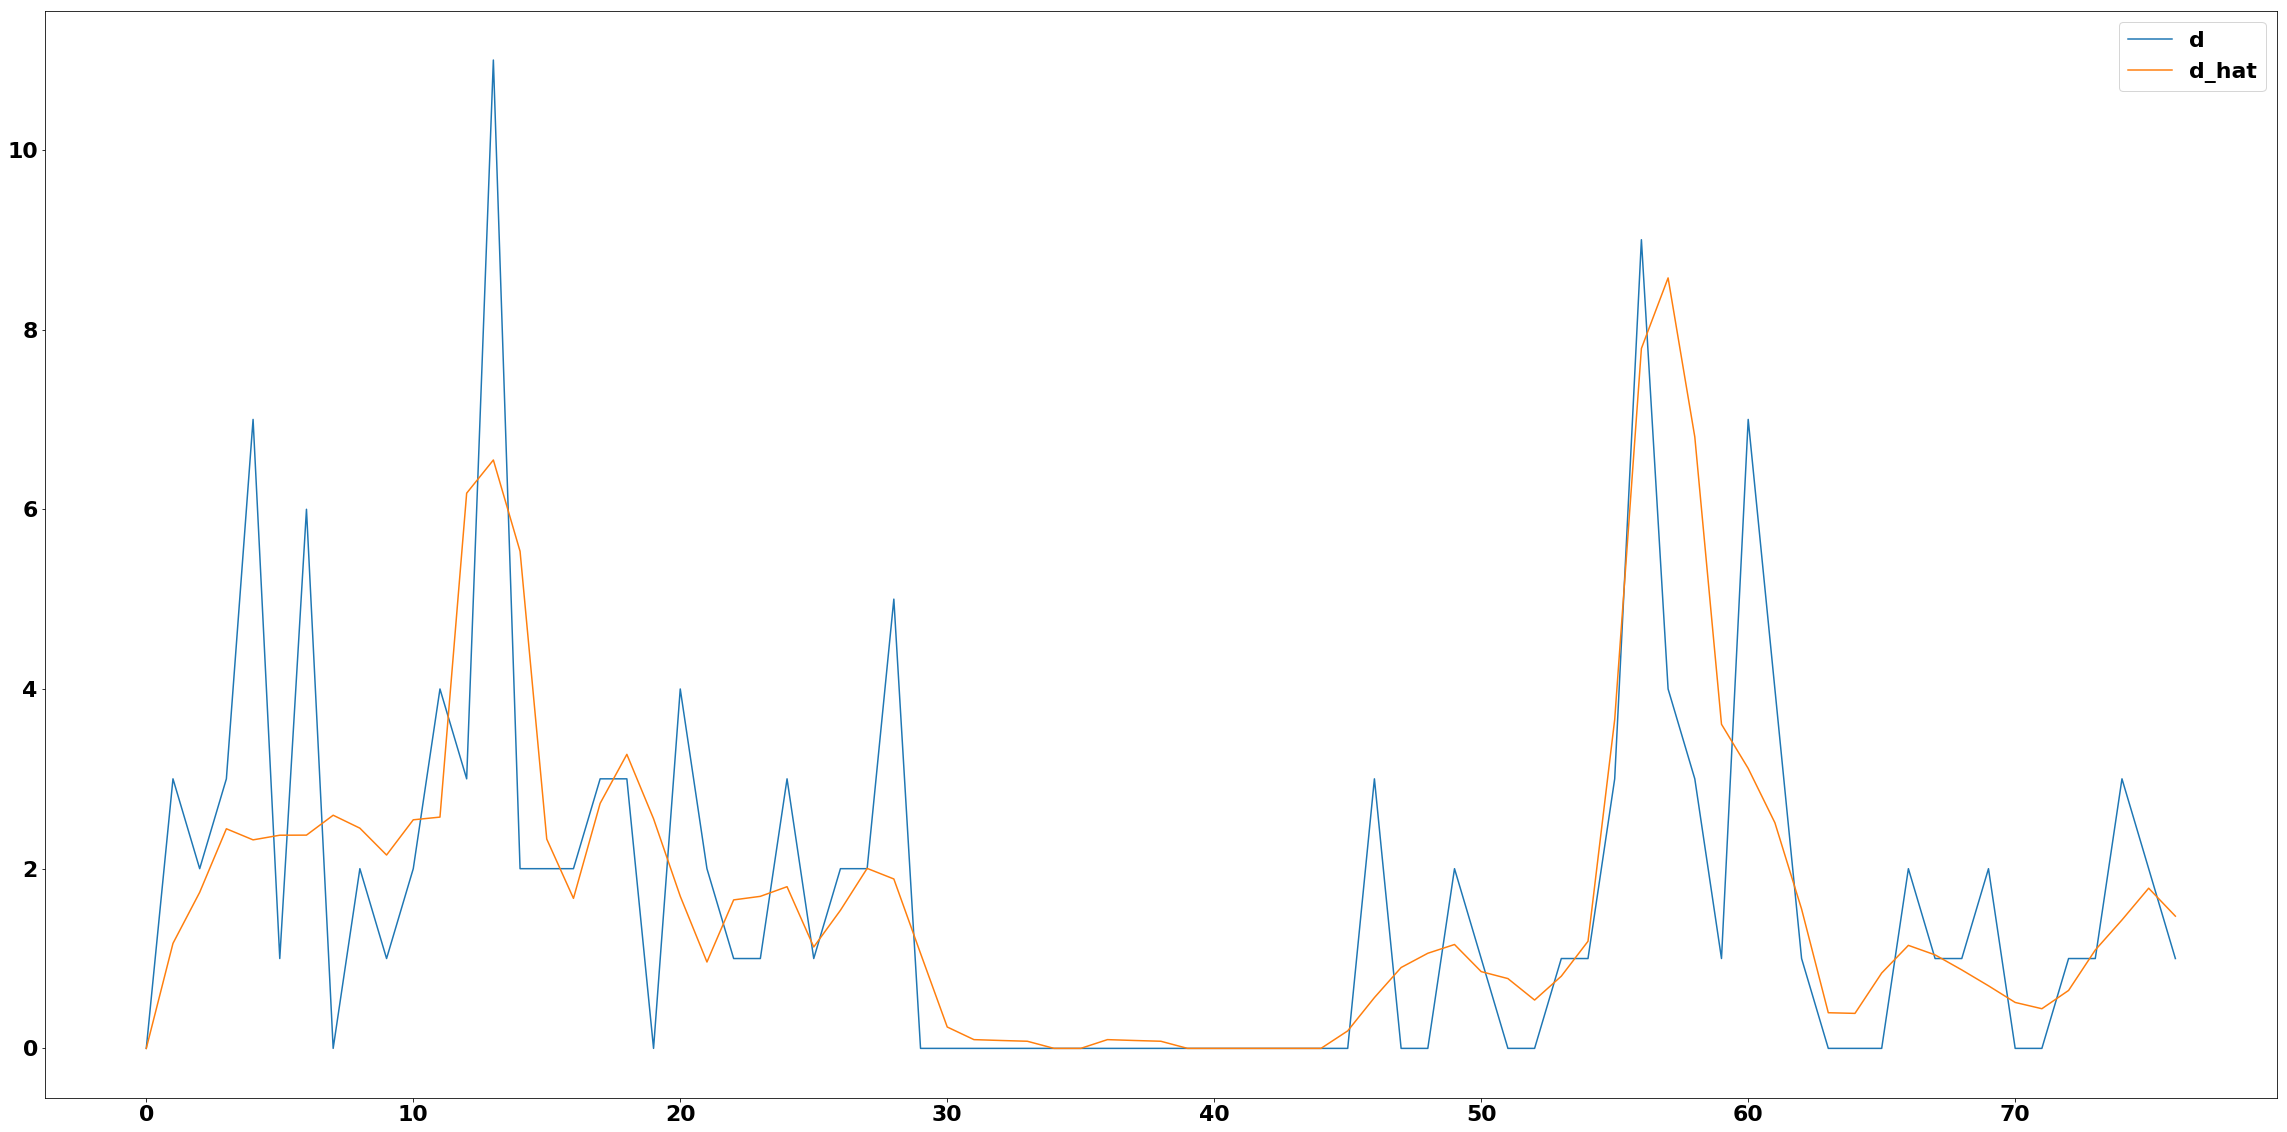

In [71]:
estimate_death_curve(
    smooth_mers_ts['Infected'].values,
    smooth_mers_ts['Dead'].values,
    S_mers
).plot()

Clearly, there are two sepeare outbreaks in this dataset. One ending before week 60 (seems like week 57) and the other starting at week 90.

In [72]:
first_mers_ts = smooth_mers_ts.loc[:"2018-01-28"]
second_mers_ts = smooth_mers_ts.loc["2018-09-09":]

Minimum distance=10.908326452760754
Minimum d_hat=[0.    1.2   1.78  2.502 2.377 2.429 2.43  2.658 2.509 2.202 2.607 2.636
 6.335 6.708 5.654 2.381 1.712 2.795 3.351 2.614 1.732 0.984 1.694 1.733
 1.841 1.155 1.575 2.053 1.929]
Minimum K=3


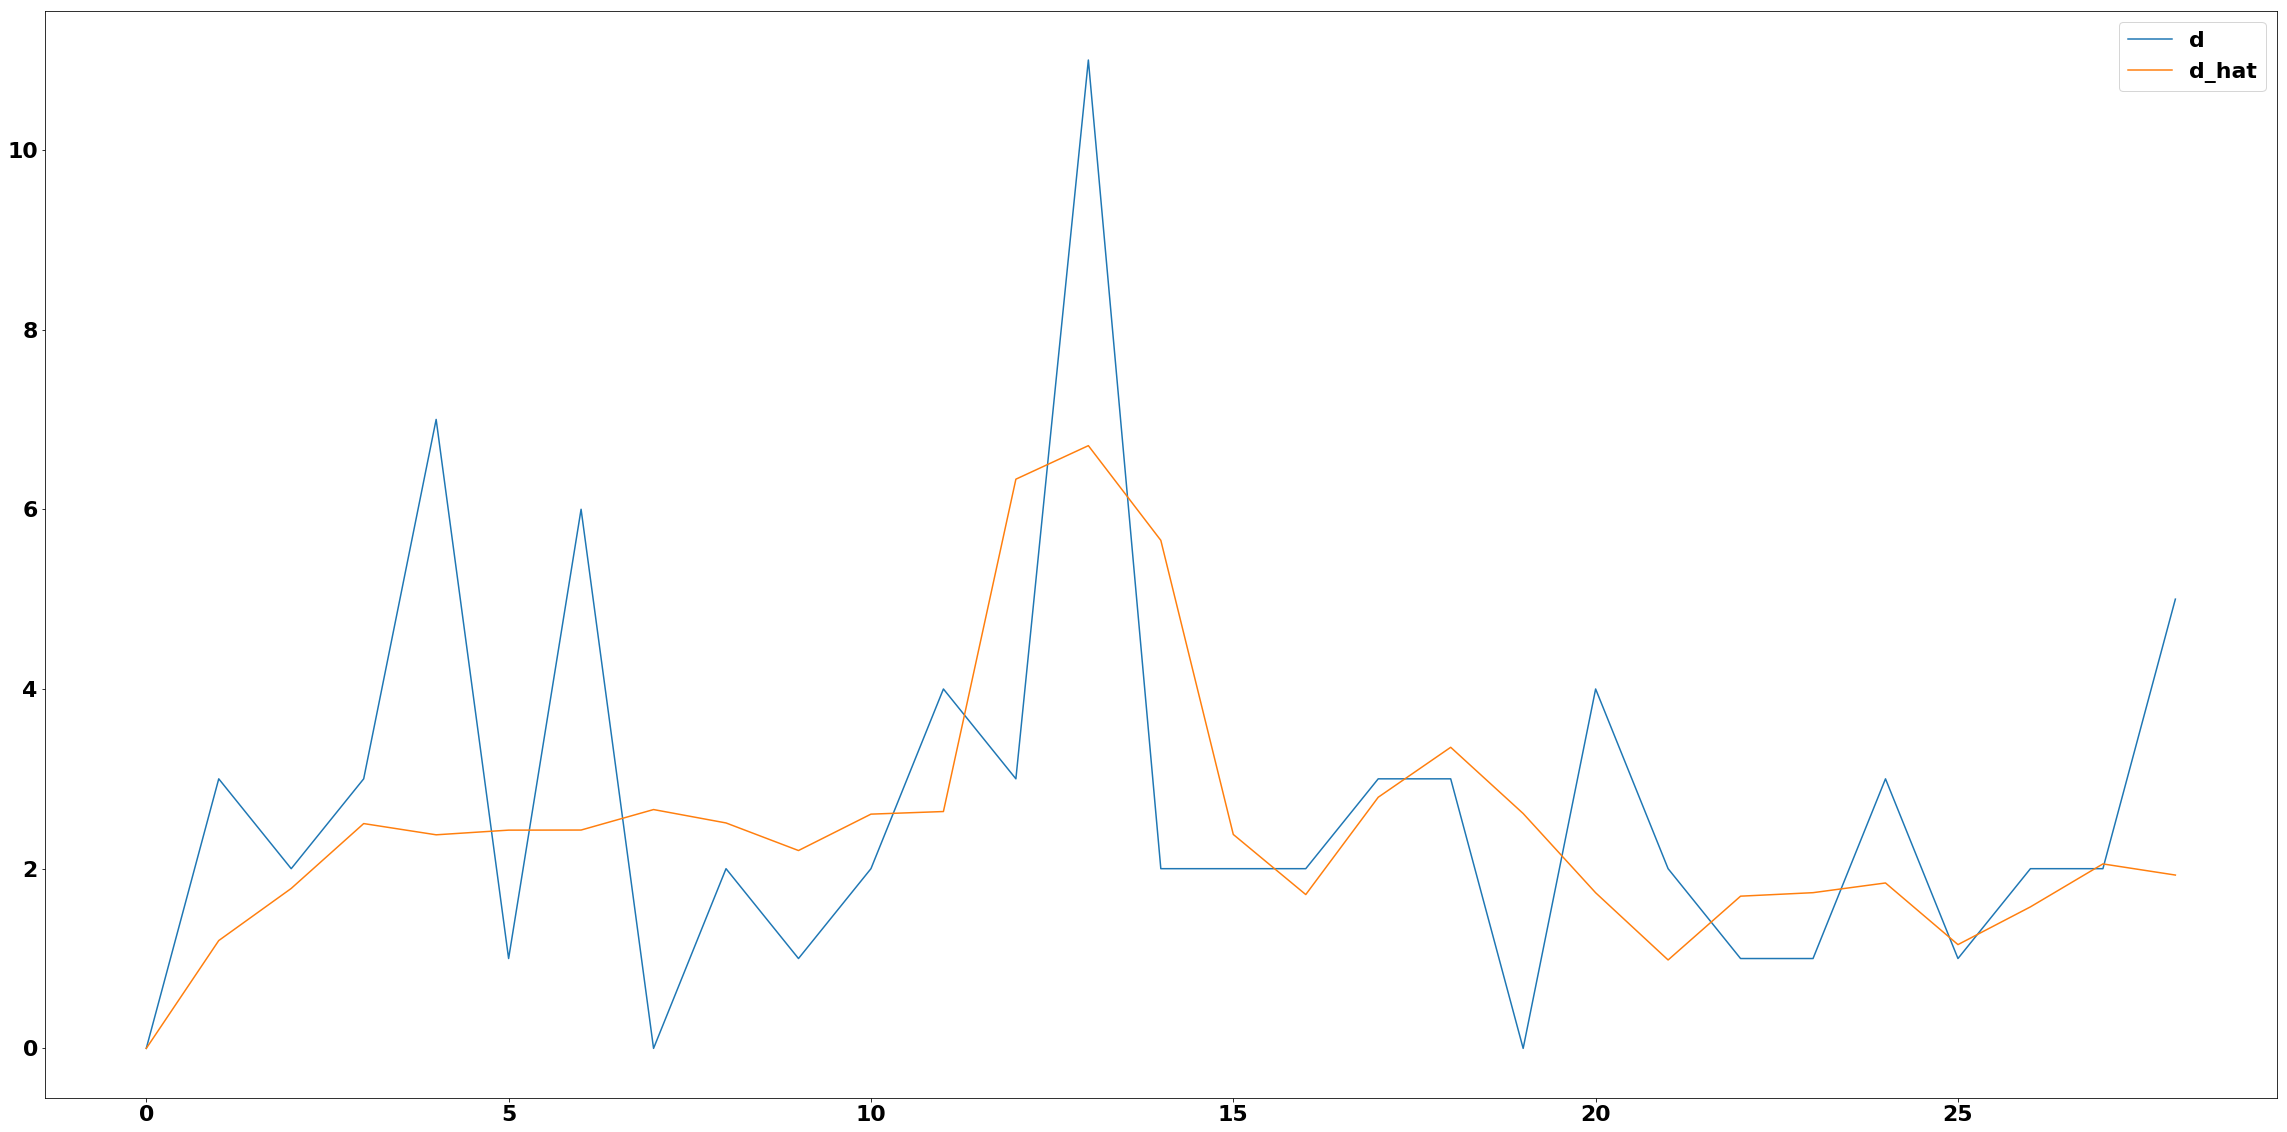

In [73]:
estimate_death_curve(
    first_mers_ts['Infected'].values,
    first_mers_ts['Dead'].values,
    S_mers
).plot()

Minimum distance=8.870906980172112
Minimum d_hat=[0.         0.3896     0.74125296 1.05865492 1.15605492 0.85436816
 0.77686569 0.53789021 0.80347795 1.19215394 3.65999464 7.78962415
 8.57496249 6.80575207 3.60740594 3.11558779 2.51129026 1.55047307
 0.39675245 0.3896     0.83865296 1.14656816 1.04060541 0.87334168
 0.69659119 0.51127795 0.44141422 0.64477697 1.09475394 1.4292814
 1.78278238 1.47160886]
Minimum K=3


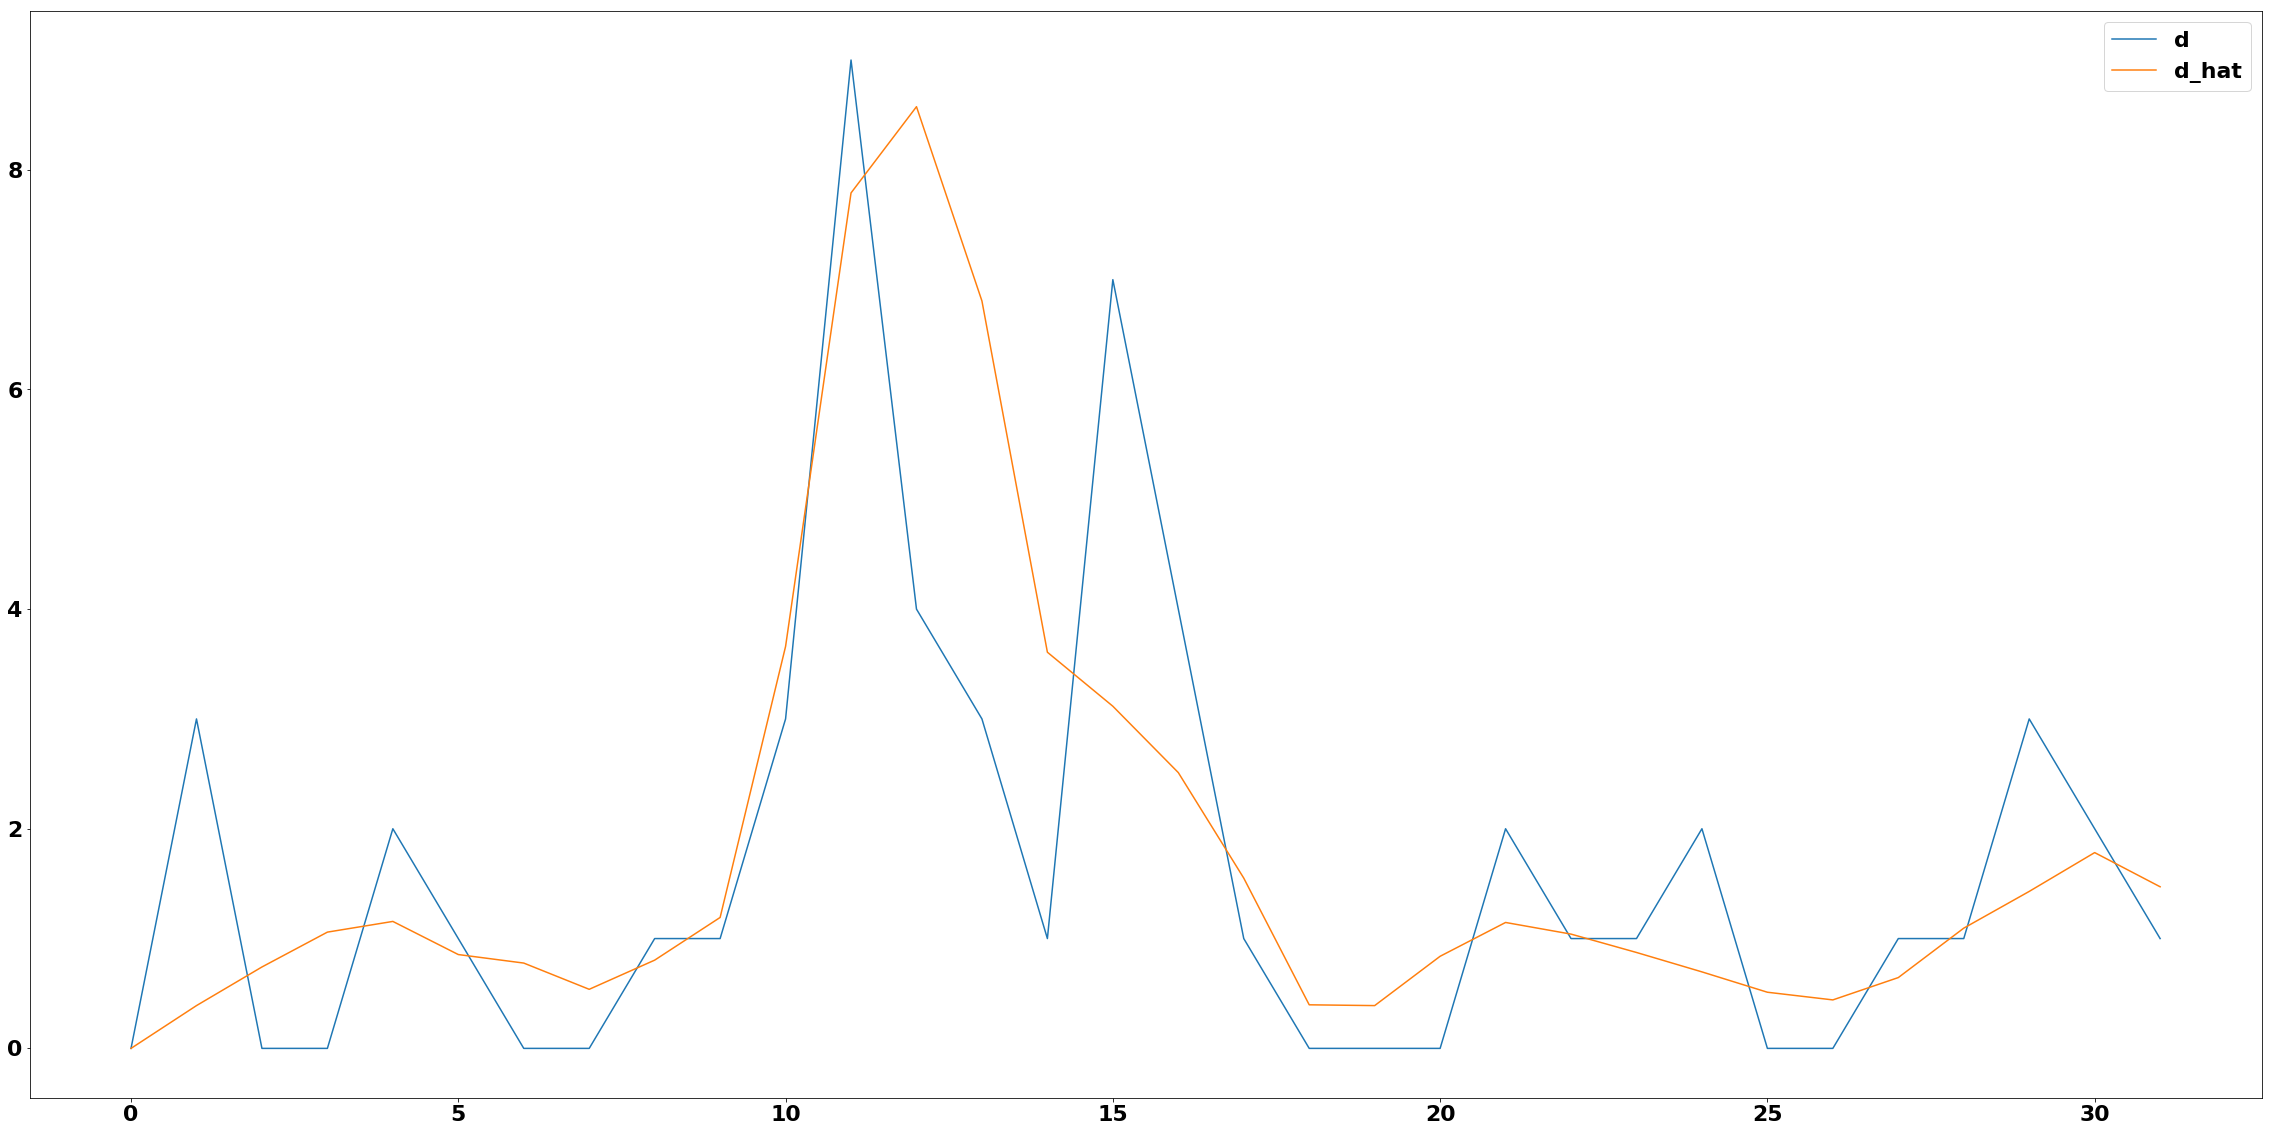

In [74]:
estimate_death_curve(
    second_mers_ts['Infected'].values,
    second_mers_ts['Dead'].values,
    S_mers
).plot()